## Assignment 2 
### Date: November 2019
### Name: Mouselinos Spyridon

***
### Lets Try to Load the Data into a Pandas Dataframe
***

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('darkgrid')

In [3]:
## Set the stata file location as well as disable any pandas warnings

In [4]:
stata_file_location = './WCRWreplication.dta'
pd.set_option('mode.chained_assignment', None)

### Correct way to read stata even of large size ###
### [Click Here For Gist](https://gist.github.com/aflaxman/4ec656c1127b214e32ff)

In [5]:
def loadStata(fname):
    reader = pd.read_stata(fname, iterator=True)
    df = pd.DataFrame()
    try:
        print("Loading...")
        chunk = reader.get_chunk(100*1000)
        while len(chunk) > 0:
            df = df.append(chunk, ignore_index=True)
            chunk = reader.get_chunk(100*1000)
            print(".")
            sys.stdout.flush()
    except (StopIteration, KeyboardInterrupt):
        pass
    print('\nLoaded {} rows'.format(len(df)))
    return df

In [6]:
data = loadStata(fname=stata_file_location)
### We will need a fresh copy for question 4 ##
ex_4_data = data.copy()
### We will need a fresh copy for question 5 ##
ex_5_data = data.copy()
### We will need a fresh copy for question 6 ##
ex_6_data = data.copy()
### We will need a fresh copy for question 7 ##
ex_7_data = data.copy()

Loading...

Loaded 323 rows


## 1. Frequency of Nonviolent and Violent Campaign End Years

Create a plot showing the frequency of nonviolent and violent campaigns; the frequency should be counted based on their end years, at decades. The violent and nonviolent campaign counts should be stacked on each other.

In [7]:
## End Year Column Name : eyear
## Violent / Non - Violent Column Name : nonviol / viol as dummy categorical values

In [8]:
# Lets Gather all the Non-Violent Campaigns into one Frame
nvdf = data[data['nonviol'] == 1]

# Lets Create A Decade Column
nvdf['decade'] = (nvdf['eyear'] // 10)*10

In [9]:
# Lets Gather all the Violent Campaigns into one Frame
vdf = data[data['viol'] == 1]

# Lets Create A Decade Column
vdf['decade'] = (vdf['eyear'] // 10)*10

In [10]:
# Check if we missed anything
assert data.shape[0] == vdf.shape[0] + nvdf.shape[0]

In [11]:
# Group By the decades and count frequencies of Non-Violent Campaigns
nv_count = nvdf.groupby(['decade']).size()

In [12]:
# Group By the decades and count frequencies of Violent Campaigns
v_count = vdf.groupby(['decade']).size()

In [13]:
time_axis_x = range(1900,2010,10)

In [14]:
### Small HotFix for Non-Violent onces since they have 0 occurencies in 1900's

In [15]:
leading_zero = np.array([0])

In [16]:
fixed_non_violent_array = np.concatenate((leading_zero,nv_count.values),axis=0)
fixed_violent_array = v_count.values

In [17]:
stacked_frequencies_y =[fixed_violent_array,fixed_non_violent_array]

### Stack Plot of the Frequency of the Two Campaign Types
### [Reference for Stack Plot](https://python-graph-gallery.com/251-stacked-area-chart-with-seaborn-style/)

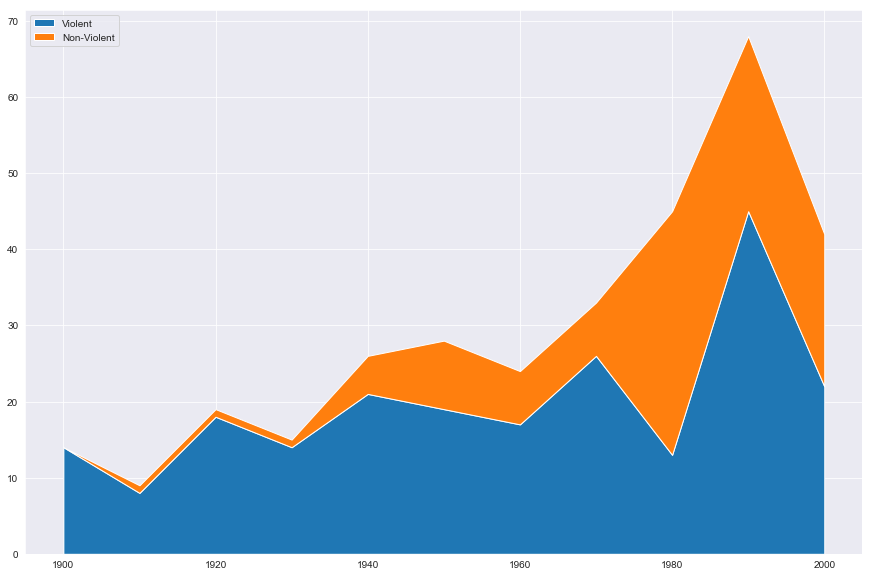

In [18]:
plt.figure(figsize=(15,10))
plt.stackplot(time_axis_x,stacked_frequencies_y, labels=['Violent','Non-Violent'])
plt.legend(loc='upper left')
plt.show()

***
***

## 2: Number of Nonviolent Campaigns and Percentage of Success

Create a plot showing, for each decade from 1940 onwards, the number of nonviolent campaigns and the percentage of success.

In [19]:
## Lets narrow down our data from 1940 and afterwards regarding non-violent campaigns

In [20]:
plot_data = nvdf[nvdf['decade'] >= 1940]

### In order to count the percentage of success we will accumulate the column 'success'.
***
#### As mentioned in the appendix:
#### SUCCESS: Dichotomous variable identifying whether the campaign achieved 100% of its stated goals within a year of the peak of activities.

In [21]:
plot_data = plot_data.groupby(['decade']).success.agg(['count', 'sum'])

In [22]:
plot_data['rate'] = plot_data['sum'] / plot_data['count']

In [23]:
## We dont need them anymore

In [24]:
del plot_data['count']
del plot_data['sum']

In [25]:
## Restore the count of non-violent campaigns from before

In [26]:
plot_data['number'] = fixed_non_violent_array[4:]

In [27]:
### We can have them now in a nice DataFrame
plot_data

,rate,number
decade,,
1940,0.400000,5
1950,0.333333,9
1960,0.428571,7
1970,0.571429,7
1980,0.531250,32
1990,0.521739,23
2000,0.700000,20


###  Double Bar Chart Twinx Code
### [Reference](https://stackoverflow.com/a/24183505)

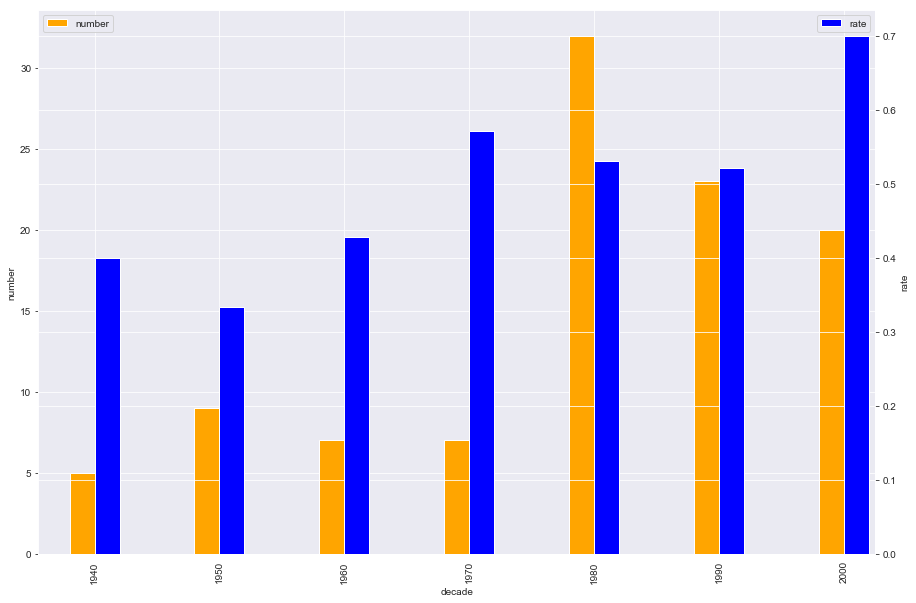

In [28]:
fig = plt.figure(figsize=(15,10)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.2
plot_data.rate.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
plot_data.number.plot(kind='bar', color='orange', ax=ax, width=width, position=1)
ax2.set_ylabel('rate')
ax.set_ylabel('number')
ax.legend(loc=2)
ax2.legend(loc=0)
plt.show()

***
***

## 3: Success Rate by Decade

Create a plot showing the success rate for violent and nonviolent campaigns by decade.

In [29]:
## For the sake of completeness let's recalculate the steps for violent campaigns 
## Note: vdf == Violent DataFrame
##      nvdf == Non - Violent Dataframe

In [30]:
vdf_data = vdf[vdf['decade'] >= 1940]
vdf_data = vdf_data.groupby(['decade']).success.agg(['count', 'sum'])
vdf_data['rate'] = vdf_data['sum'] / vdf_data['count']
vdf_data['violence'] = 'violent'
del vdf_data['count']
del vdf_data['sum']

In [31]:
### Lets get the previous data and rename them to make sense

In [32]:
nvdf_data = plot_data[['rate']]
nvdf_data['violence'] = 'non-violent'
data = pd.concat([vdf_data, nvdf_data], axis=0)
data.reset_index(inplace=True)

In [33]:
### Now lets make the Plot

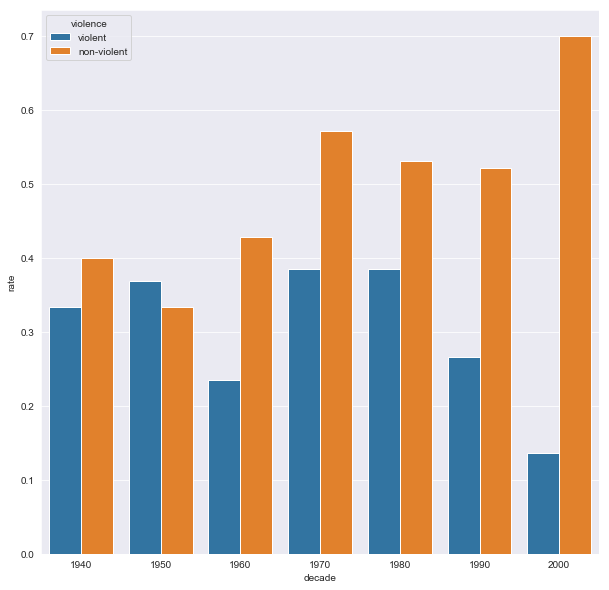

In [34]:
plt.figure(figsize=(10,10))
_ = sns.barplot(x="decade", y="rate", hue="violence", data=data)
plt.show()
plt.close()

***
***

## 4. Twenty-Five Largest Resistance Campaigns, 1900-2006

Create a table with the twenty-five largest resistance campaigns, for all years, based on their number of members at highest point (peak membership). The table should include the membership, the start year, the end year, the location, the target, whether it was violent or not, and whether it was successful or not. Notice if you find anything about Greece.

In [35]:
### We have kept the original data as ex_4_data
### Lets rename them

In [36]:
data = ex_4_data

***
***
### Note:(This observation happened after finishing exersize 4) I could not understand what was the numeric system of the population i found out that the lnpop column was in fact in millions as i cross checked with google stats.
 

In [37]:
note_data = data[['peakmembership','eyear','location','lnpop','lmembers','mempc']]
note_data = note_data.sort_values(by=['peakmembership'],ascending=False).head(25)
note_data.reset_index(inplace=True,drop=True)
note_data.loc[16]

peakmembership     500000
eyear                1963
location           Greece
lnpop             9.03968
lmembers          13.1224
mempc             1.45164
Name: 16, dtype: object

In [38]:
### Ok by transforming back the lnpop with the e based logarithm we get:
normalized_population = np.exp(note_data.loc[16,'lnpop'])
print(normalized_population)

8431.099


### Now let's perform a simple Google Search about Greece Population around that time:
Its 8,463 millions according to [this](https://www.google.com/search?q=greece+population+1963&oq=gree&aqs=chrome.0.69i59j69i57.900j0j7&sourceid=chrome&ie=UTF-8)

In [39]:
### So the lnpop needs to be transformed by multiplying with 1000 to get the real number
real_population = normalized_population * 1000
print(real_population)

8431098.6328125


### Lets see if that holds also with the membership

In [40]:
lnpop = note_data.loc[16,'lnpop']
lmembers = note_data.loc[16,'lmembers']
mempc = note_data.loc[16,'mempc']

pop = np.exp(lnpop)
memebers = mempc * lnpop
print(np.exp(memebers))
print(np.exp(lmembers))

499999.84
499999.84


### So indeed by just taking the mempc * lnpop we get the lnmembership in the correct log scale
### End of Note

***
***
### Ok let's continue with the exersize

In [41]:
data = data[['peakmembership','byear','eyear','location','target','viol','nonviol','success']]

In [42]:
top_25 = data.sort_values(by=['peakmembership'],ascending=False).head(25)
top_25.reset_index(inplace=True,drop=True)

In [43]:
top_25

,peakmembership,byear,eyear,location,target,viol,nonviol,success
0,4500000.0,1937,1945,China,Japanese occupation,1,0,0
1,2000000.0,1977,1979,Iran,Shah Reza Pahlavi,0,1,1
2,2000000.0,1986,1983,Philippines,Ferdinand Marcos,0,1,1
3,1000000.0,1988,1988,Burma,military junta,0,1,0
4,1000000.0,1989,1989,China,Communist regime,0,1,0
5,1000000.0,1967,1968,China,anti-Maoists,1,0,0
6,1000000.0,1922,1949,China,Kuomintang regime,1,0,1
7,1000000.0,2006,2006,Mexico,Calderon regime,0,1,0
8,1000000.0,2005,2005,Lebanon,Syrian forces,0,1,1
9,1000000.0,1993,1999,Nigeria,Military rule,0,1,1


In [44]:
## Interestingly we find at entry with Index 16 a campaign in Greece
top_25.loc[16]

peakmembership               500000
byear                          1963
eyear                          1963
location                     Greece
target            Karamanlis regime
viol                              0
nonviol                           1
success                           1
Name: 16, dtype: object

### Here is a relevant [link](https://el.wikipedia.org/wiki/%CE%95%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%AD%CF%82_%CE%B2%CE%BF%CF%85%CE%BB%CE%B5%CF%85%CF%84%CE%B9%CE%BA%CE%AD%CF%82_%CE%B5%CE%BA%CE%BB%CE%BF%CE%B3%CE%AD%CF%82_1963) about the regime and the elections

***
***

## 5. The Effect of Participation on the Probability of Campaign Success

Examine the effect of participation on the probability of campaign success. You should run a logistic regression for success on membership per capita, controlling for the location’s logged population the year the campaign ends. Explain your results.

Having done that, create a scatter plot showing the logged participants per capita, on the $x$ axis, and the probability of success, on the $y$ axis.

In [45]:
### First of all lets pinpoint the columns we need:
### Location’s logged population the year the campaign ends, logged --> LNPOP
### Membership per capita --> MEMPC
### Success --> SUCCESS

In [46]:
data = ex_5_data[['success','mempc','lnpop']]

In [47]:
data['success'] = data['success'].astype(float)

In [48]:
## Lets drop the N/A rows

In [49]:
data.dropna(inplace=True)

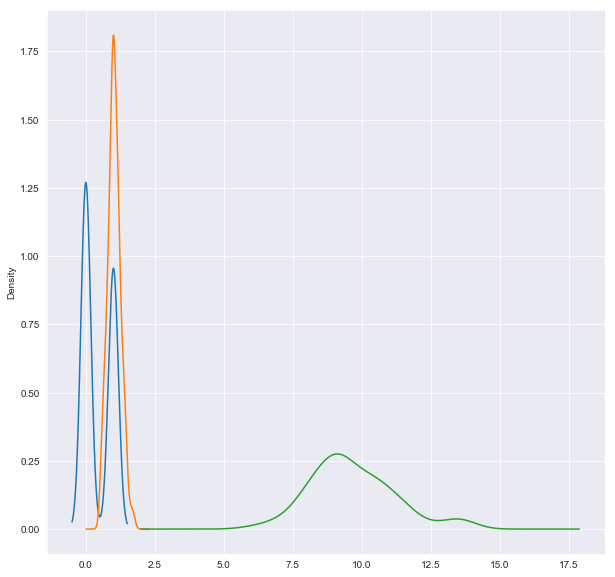

In [50]:
## Lets visualize the Distributions
plt.figure(figsize=(10,10))
for column in data.columns:
    data[column].plot.kde()
plt.show()
plt.close()

In [51]:
### Now lets see how well can we split them by line

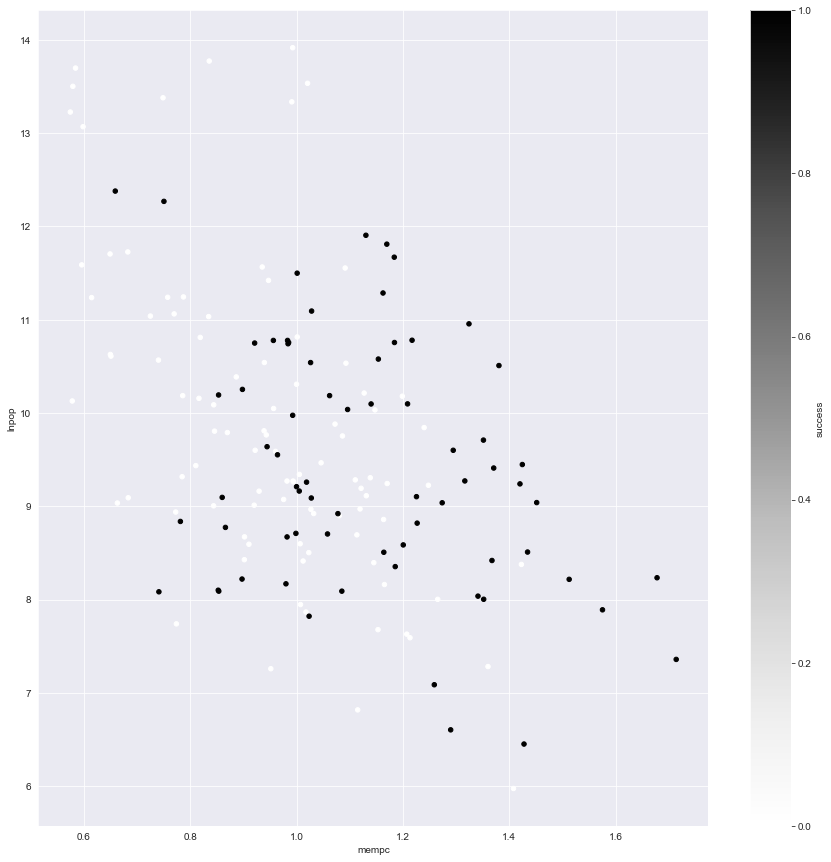

In [52]:
_ = data.plot.scatter(x='mempc', y='lnpop', c='success',figsize=(15,15))

In [53]:
from statsmodels.formula.api import logit

In [54]:
### Lets start simply by invoking a function of a form success = intercept + b0*mempc + b1*lnpop

In [55]:
logRegressor = logit("success ~ mempc + lnpop", data)
res = logRegressor.fit()
print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.594790
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.129     
Dependent Variable: success          AIC:              199.9014  
Date:               2019-11-30 10:54 BIC:              209.1827  
No. Observations:   163              Log-Likelihood:   -96.951   
Df Model:           2                LL-Null:          -111.35   
Df Residuals:       160              LLR p-value:      5.5508e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -5.8199    1.9207  -3.0301  0.0024  -9.5843  -2.0555
mempc          4.4892    0.9857   4.5545  0.0000   2.5573   6.

* We observe a low value in the Pseud R squared value, meaning that with our 2 independent variables we can explain a small ~ 13% percentage of the independent variables variance. This is normal due to the small number of parameters used.

* One unit increase in the mempc measure brings an increase of 4.4892 in the log odds of a successful campaign; equivalently, as $e^{4.4892} \approx 89.05$, the odds of successful campaign increase by about 89.05%.


* One unit increase in the lnpop measure brings an increase of 0.0907 in the log odds of a successful campaign; equivalently, as $e^{0.0907} \approx 1.094$, the odds of successful campaign increase by about 1.094%.


* The intercept is the log odds of success when all the independent variables are held at zero; that is $e^{-5.8199} \approx 0.002$.

In [56]:
### Confusion Matrix
res.pred_table()

array([[70., 23.],
       [34., 36.]])

In [57]:
### Extract the coefficient array

In [58]:
coeff_array = res.summary2().tables[1]['Coef.'].values

### Visualizations that can give insight

In [59]:
## Lets created an approximation of the fitted function
## with the variable lnpop kept at its mean value 
## For visualisation purposes only 

def approximation_of_fitted_logistic_function(input_data, coeff_array=None):
    return 1 /(1 + np.exp(-(coeff_array[0] + coeff_array[2]*data['lnpop'].mean() + coeff_array[1]*input_data)))

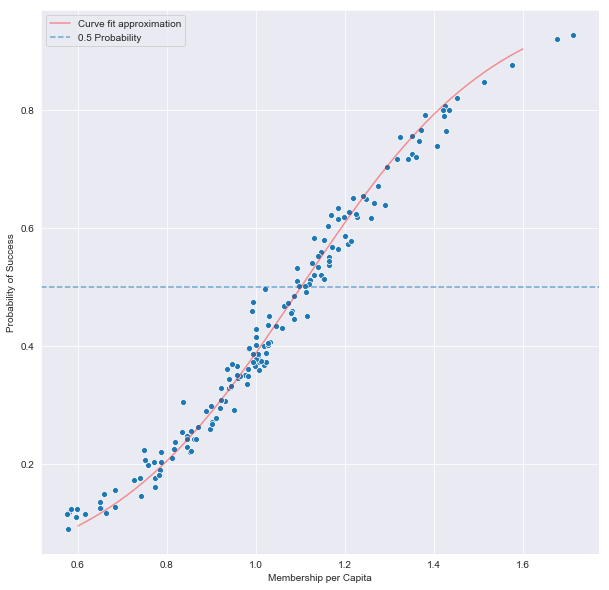

In [60]:
x = data['mempc'].values
y = res.predict(exog=dict(mempc=data['mempc'].values,lnpop=data['lnpop'].values)).values
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=x, y=y)
ax2 = sns.lineplot(x=np.linspace(0.6,1.6,163), y=approximation_of_fitted_logistic_function(np.linspace(0.6,1.6,163),coeff_array),alpha=0.4,color='r',label='Curve fit approximation')
ax.axhline(0.5, ls='--',alpha=0.6,label='0.5 Probability')
plt.xlabel('Membership per Capita')
plt.ylabel('Probability of Success')
plt.legend(loc='upper left')
plt.show()
plt.close()

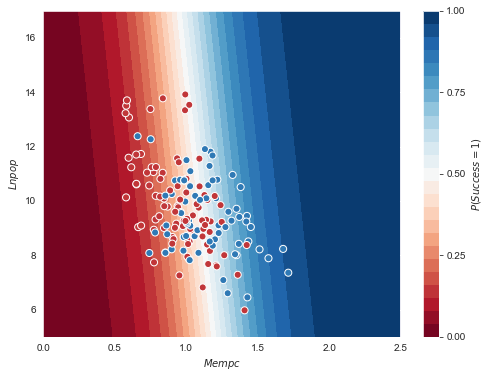

In [61]:
### Visualization of splitting point
### First lets see the boundary we already calculated
import numpy as np
xx, yy = np.mgrid[0:+2.5:.01, 5:+17:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
######################
probs = res.predict(exog=dict(mempc=grid[:,0],lnpop=grid[:,1])).values
probs = probs.reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1);
ax_c = f.colorbar(contour);
ax_c.set_label("$P(Success = 1)$");
ax_c.set_ticks([0, .25, .5, .75, 1]);

ax.scatter(data['mempc'].values, data['lnpop'].values, c=data['success'].values, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1);

ax.set(
       xlim=(0, 2.5), ylim=(5, 17),
       xlabel="$Mempc$", ylabel="$Lnpop$"
);

## 6. The Level of Participation Tipping Point

From the results you obtained in the previous question, find the percentage of the population that is the tipping point for success in a campaign.

### One way to solve the problem
***

#### We notice that the tipping point occurs at the p=0.5 point
#### That means that the prob function equals to 0 =  coeff[0] + coeff[1] * mempc + coeff[2] * lnpop
#### Meaning that lmember = lnpop * (-coeff[0] - coeff[2] * lnpop) / coeff[1]
#### And subsequently member = np.exp(lnpop * (-coeff[0] - coeff[2] * lnpop) / coeff[1])
#### In that manner we have a function of two variables that can give us the tipping point by holding one as depentent and the other one independent

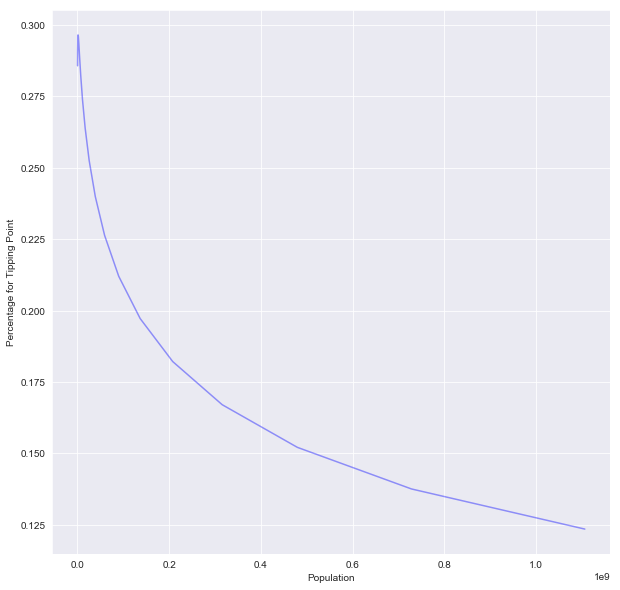

In [62]:
### Lets hold as x the lnpop and as y the mempc.
lnpop_array = np.linspace(data['lnpop'].min(),data['lnpop'].max(),20)
def get_membership(lnpop, coeff_array=None):
    return np.exp(lnpop*(-coeff_array[0] - coeff_array[2]*lnpop)/coeff_array[1])
def get_population(lnpop):
    return np.exp(lnpop)*1000
y = get_membership(lnpop_array,coeff_array)
x = get_population(lnpop_array)
p = 100*(y/x)
_,  ax = plt.subplots(figsize=(10,10))
sns.lineplot(x=x, y=p,alpha=0.4,color='b')
plt.xlabel('Population')
plt.ylabel('Percentage for Tipping Point')
plt.show()
plt.close()

#### With the above diagram we can give an estimate of the percentage of the population 
#### that is the tipping point as a range: [0.13- 0.3]%

### Another way to solve the problem
***

#### Another idea would be to predict again the probabilities of the data rows.
#### Then order them by it and gather the values around the 0.5 point.
#### Calculate the percentages of each of the datapoints around the area and finally answer 
#### with a confidence interval around that value.

In [63]:
data.reset_index(inplace=True,drop=True)
x = data['mempc'].values
y = res.predict(exog=dict(mempc=data['mempc'].values,lnpop=data['lnpop'].values)).values
data['probas'] = y
data = data.sort_values('probas')
data = data[(data['probas'] >= 0.45) & (data['probas'] <= 0.55)]
data['population'] = np.exp(data['lnpop'].values) * 1000
data['lmembership'] = data['mempc'] * data['lnpop']
data['membership'] = np.exp(data['lmembership'].values)
data['percentage'] = 100*(data['membership'] / data['population'])
data.reset_index(inplace=True,drop=True)
print("The interval of percentage is {:.3f}% : {:.3f}%".format(data.loc[0,'percentage'],data.loc[data.shape[0]-1,'percentage']))

The interval of percentage is 0.137% : 0.404%


## 7. Nonviolent Resistance, Target Regime Type, Geographical Location

1. Examine whether nonviolent resistance remains significant even if we control for the regime type. Run a logistic   regression of success on the nonviolence indicator controlling for the POLITY IV score of campaign target (`tpolity`), the log of peakmembership, and the location’s logged population the year the campaign ends.

In [65]:
data = ex_7_data

In [66]:
data = data[['success','nonviol','tpolity','lmembers','lnpop', 'middleeast', 'americas', 'asia', 'fsu', 'europe', 'africa']]

In [67]:
data.dropna(inplace=True)

In [76]:
### Lets see the nonviolent resistance significance when we dont control for the regime type

In [74]:
### Without Control of the polity iv score
logRegressor = logit("success ~ C(nonviol) + lmembers + lnpop", data)
res = logRegressor.fit()
print(res.summary2())
### Confusion Matrix
print(res.pred_table())

Optimization terminated successfully.
         Current function value: 0.578218
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.146     
Dependent Variable: success          AIC:              171.0575  
Date:               2019-11-30 10:57 BIC:              182.8525  
No. Observations:   141              Log-Likelihood:   -81.529   
Df Model:           3                LL-Null:          -95.506   
Df Residuals:       137              LLR p-value:      3.7139e-06
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.0449   1.4003 -0.0321 0.9744 -2.7895  2.6997
C(nonviol)[T.1]    0.7852   0.4469  1.7567 0.0790 -0.0908  1.6612


* We still observe a low value in the Pseud R squared value, however better than before with our 3 independent variables explaining  ~ 14% percentage of the independent variables variance. 

* One unit increase (meaning the categorical variable is on in an on/off setting) in the nonviol measure brings an increase of 0.7852 in the log odds of a successful campaign; equivalently, as $e^{0.7852} \approx 2.192$, the odds of successful campaign increase by about 2.192%.


* One unit increase in the lmembers measure brings an increase of 0.3490 in the log odds of a successful campaign; equivalently, as $e^{0.3490} \approx 1.417$, the odds of successful campaign increase by about 1.417%.


* One unit increase in the lnpop measure brings a decrease of -0.4225 in the log odds of a successful campaign; equivalently, as $e^{-0.4225} \approx 0.655$, the odds of successful campaign  decrease by about 0.655%.


* The intercept is the log odds of success when all the independent variables are held at zero; that is $e^{-0.0449} \approx 0.956$.

In [75]:
### Lets see the now nonviolent resistance significance when we control for the regime type

In [77]:
### With Control of the polity iv score

In [78]:
logRegressor = logit("success ~ C(nonviol) + tpolity + lmembers + lnpop", data)
res = logRegressor.fit()
print(res.summary2())
print(res.pred_table())

Optimization terminated successfully.
         Current function value: 0.567143
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.163     
Dependent Variable: success          AIC:              169.9344  
Date:               2019-11-30 10:59 BIC:              184.6782  
No. Observations:   141              Log-Likelihood:   -79.967   
Df Model:           4                LL-Null:          -95.506   
Df Residuals:       136              LLR p-value:      2.9528e-06
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.1085   1.4130 -0.0768 0.9388 -2.8779  2.6609
C(nonviol)[T.1]    0.9048   0.4636  1.9517 0.0510 -0.0038  1.8134


#### Now that we controll for the regime type we observe:
***
* One unit increase in the tpolity measure brings an increase of 0.0520 in the log odds of a successful campaign; equivalently, as $e^{0.0520} \approx 1.053$, the odds of successful campaign increase by about 1.053%.


* One unit increase (meaning the categorical variable is on in an on/off setting) in the nonviol measure brings an increase of 0.9048 instead of 0.7852 in the log odds of a successful campaign; equivalently, as $e^{0.9048} \approx 2.471$, the odds of successful campaign increase by about 2.471% in contrast with the previous 2.192%.


* One unit increase in the lmembers measure brings an increase of 0.3751 instead of 0.3490 in the log odds of a successful campaign; equivalently, as $e^{0.3751} \approx 1.455$, the odds of successful campaign increase by about 1.455% in contrast with the previous 1.417%.


* One unit increase in the lnpop measure brings a decrease of -0.4363 instead of -0.4225 in the log odds of a successful campaign; equivalently, as $e^{-0.4363} \approx 0.646$, the odds of successful campaign  decrease by about 0.646% in contrast with the previous 0.655%.


* The intercept is the log odds of success when all the independent variables are held at zero; that is $e^{-0.1085} \approx 0.897$. That means that $p / (1-p) = 0.897$

#### Overall we see that controlling for the regime type (tpolicy) does not reduce the significance of the nonviolence
#### On the other hand the variable remains fairly significant at a p value of around 0.05

***

### 2 Examine whether nonviolent resistance remains significant even if we control for geographical location of the compaign.
***

### WARNING: Using multiple categorical values in an encoded manner may lead to the dummy variable trap. Thus, we either need to:
### A) Remove one of the categories of the countries
### B) Remove the intercept 
### So we avoid multicollinearity.
***

### Method A
### A) Remove one of the categories of the countries (Africa)

In [71]:
logRegressor = logit("success ~ C(nonviol) + C(middleeast) + C(americas) + C(asia) + C(fsu) + C(europe)", data)
res = logRegressor.fit()
print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.591100
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.127     
Dependent Variable:  success          AIC:              180.6901  
Date:                2019-11-30 10:54 BIC:              201.3314  
No. Observations:    141              Log-Likelihood:   -83.345   
Df Model:            6                LL-Null:          -95.506   
Df Residuals:        134              LLR p-value:      0.00045575
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept          -0.4405   0.3280 -1.3428 0.1793 -1.0834  0.2025
C(nonviol)[T.1]     1.3628   0.4291  3.1755 0.0015  0

### Method B
### B) Remove the Intercept Term

In [72]:
logRegressor = logit("success ~ nonviol + middleeast + americas + asia + fsu + europe + africa - 1", data)
res = logRegressor.fit()
**print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.591100
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.127     
Dependent Variable: success          AIC:              180.6901  
Date:               2019-11-30 10:54 BIC:              201.3314  
No. Observations:   141              Log-Likelihood:   -83.345   
Df Model:           6                LL-Null:          -95.506   
Df Residuals:       134              LLR p-value:      0.00045575
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
nonviol        1.3628    0.4291   3.1755  0.0015   0.5217   2.2039
middleeast    -2.2617    0.7968  -2.8383  0.0045  -3.8234  -0.

***
#### Results
***

#### After examining both results we can declare the following:
***
* The difference in interpreting the two methods lies in the intercept term. In the first case the intercept incorporates the case of the held out variable(africa) to be "on" while others are "off". In the second method by removing the intercept the coefficients are spread between all the categories of the location variable. That slight difference in interpreting the results does not however change the significance of the nonviol variable. Its is stable at a coefficient of 1.3628, meaning one unit increase brings an increase $e^{1.3628} \approx 3.907$%, in the odds of successful campaign.

* Both methods have the same Pseudo R squared value, giving credit to our assumption that they are "two different sides of the same coin". However, the value is relatively small , meaning we cant explain well the success factor, based only on them.

* Campaigns in both Asia and the Middle East have a greater importance factor as variables that those in other regions. Meaning that that factor alone provides us with a great bias towards the result of those campaings. That bias is mainly negative due to the coeff being less than 0. So we can conclude that in those regions its really hard to succeed even with a non-violent approach.